In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import data_extraction as da
import modelling as md
import plotting
from matplotlib.ticker import MaxNLocator
import utils

# TODO: comment on franchises
# TODO: add confirmed genres to ratings table, primary/secondary, studio?

# Prediction on unseen films (Annie Hall, Chariots of Fire, The Silence of the Lambs, The Departed)

INFO - 2025-07-09 17:25:57,104 - PyTorch version 2.7.1 available.
[nltk_data] Downloading package stopwords to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Batman V Superman Dawn of Justice subtitles are garbage,
Shang-Chi and the Legend of the Ten Rings,
Minari,
Lincoln

In [2]:
raw_films_list_df = da.get_or_create_subtitles_data(os.path.join(da.sub_dir, 'movie_index.parquet'), da.sub_dir)
films_list_df = raw_films_list_df[raw_films_list_df.year.ge(2013)].reset_index(drop=True).copy()

full_subs_df_list = []

for movie_cat in ('Blockbusters', 'Oscar'):
    for year in films_list_df.year.unique():
        year_dir = os.path.join(da.sub_by_year_dir, movie_cat, str(year))
        for movie_fp in os.listdir(year_dir):
            curr_df = da.extract_single_subs_file(os.path.join(year_dir, movie_fp))
            full_subs_df_list.append(curr_df)
          
for movie in os.listdir(da.add_sub_dir):
    if movie.endswith('.srt'):
        curr_df = da.extract_single_subs_file(os.path.join(da.add_sub_dir, movie))
        full_subs_df_list.append(curr_df)
    
full_subs_df = pd.concat(full_subs_df_list)

full_subs_df['movie'] = da.clean_movie_name_series(full_subs_df['movie'])
films_list_df['movie'] = da.clean_movie_name_series(films_list_df['movie']).str.replace("'", ' ').str.replace('&', 'and').str.title()

combined_subs_df = full_subs_df.merge(films_list_df, how='left')
combined_subs_df.to_parquet(da.sub_df_dir)

all_transcripts_df_list = []
longitudinal_movies = [utils.remove_ext(x) for x in os.listdir(da.trans_mp3_dir)]

for filename in os.listdir(da.transcription_dir):
    movie = filename.removesuffix(da.transcript_df_fp.format(movie_name=''))
    if movie in longitudinal_movies:
        all_transcripts_df_list.append(pd.read_parquet(os.path.join(da.transcription_dir, filename)))

all_transcripts_df = pd.concat(all_transcripts_df_list)
all_transcripts_df.to_parquet(da.all_transcripts_df_dir)

In [3]:
# All mp3s placed in a sub directory have been filtered out according to the name of their directory
mp3s_list = [x for x in os.walk(da.trans_mp3_dir)]
filtered_movies = [utils.remove_ext(y) for x in mp3s_list[1:] for y in x[2]]
filtered_movies = [x.replace('-', ' ').replace('.', '').title() for x in filtered_movies]

In [4]:
trans_df = pd.read_parquet(da.all_transcripts_df_dir)
subs_df = pd.read_parquet(da.sub_df_dir)

subs_df['movie'] = subs_df['movie'].str.title()
trans_df['movie_name'] = trans_df['movie_name'].str.strip().str.replace('-', ' ').str.replace('.', '').str.title()

trans_df['text_len'] = trans_df.text.str.len()
text_count = trans_df.groupby('movie_name').text_len.sum().reset_index()
poorly_transcribed_movies = text_count[text_count.text_len < 9000].movie_name.to_list()

# trans_df = trans_df[~trans_df.movie_name.isin(poorly_transcribed_movies)].reset_index(drop=True)

In [5]:
# Check films that struggled to identify narrator correctly
poorly_transcribed_movies

[]

In [6]:
red_trans_df = trans_df[trans_df.text.ne(' Thank you.') & trans_df.text.ne('')].copy().reset_index(drop=True)
red_trans_df['start_time'] = pd.to_timedelta(red_trans_df['uncut_start'], unit='s')
red_trans_df['end_time'] = pd.to_timedelta(red_trans_df['uncut_end'], unit='s')
red_trans_df = red_trans_df[['start_time', 'end_time', 'movie_name', 'text']].rename(columns={'movie_name': 'movie'}) #[red_trans_df.uncut_start.notna()]
red_trans_df['type'] = 'narration'

filtered_subs_df = subs_df[subs_df.movie.isin(trans_df['movie_name'].unique())].copy().reset_index(drop=True)
filtered_subs_df['text'] = filtered_subs_df['raw_dialogue'].apply(da.remove_html)
filtered_subs_df = filtered_subs_df[['start_time', 'end_time', 'movie', 'text']]
filtered_subs_df['type'] = 'dialogue'

full_txt_df = pd.concat([red_trans_df, filtered_subs_df])

/home/raine-bianchini/Documents/projects/honours/audiodescription-abusedetection/data_extraction.py:128: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text(separator=' ')


In [7]:
# Check transcriptions missing subtitles
extra_subs = [utils.remove_ext(x).title() for x in os.listdir(da.add_sub_dir)]
set(trans_df.movie_name.unique()).difference(set(list(subs_df.movie) + extra_subs))

{'Chariots Of Fire',
 'Girl In The Closet',
 'Legends Of The Hidden Temple',
 'The Adventures Of Sharkboy And Lavagirl',
 'The Departed',
 'The Last Screenwriter',
 'The Silence Of The Lambs'}

In [8]:
# Check subtitles for missing transcriptions
set(films_list_df[films_list_df.year.ge(2013)].movie).difference(set(list(trans_df.movie_name.unique()) + filtered_movies))

{'Amour',
 'Detective Chinatown 3',
 'Don T Look Up',
 'Hi, Mom',
 'Jiang Ziya',
 'Minari',
 'My People, My Homeland',
 'Roma',
 'The Battle At Lake Changjin',
 'The Eight Hundred',
 'Triangle Of Sadness',
 'Water Gate Bridge',
 'Wolf Warrior 2'}

In [17]:
raw_acb_df = da.get_acb_film_ratings()
acb_df = raw_acb_df[raw_acb_df.themes.notna()].drop(columns=['url', 'consumer_advice']).reset_index(drop=True)
acb_df['movie'] = acb_df['movie'].str.replace(':', '').str.replace('-', ' ').str.replace('.', '').str.title()
full_txt_w_acb_df = full_txt_df.merge(acb_df)
full_txt_w_acb_df.to_parquet(da.cleaned_dataset_fp)

In [18]:
# Check Full Text Films which are missing an ACB rating
set(full_txt_df['movie'].unique()).difference(set(acb_df['movie'].unique()))

{'Annie Hall',
 'Chariots Of Fire',
 'Girl In The Closet',
 'Legends Of The Hidden Temple',
 'The Adventures Of Sharkboy And Lavagirl',
 'The Departed',
 'The Last Screenwriter',
 'The Silence Of The Lambs'}

In [19]:
# Check Ratings that are missing movie text
set(acb_df['movie'].unique()).difference(set(list(full_txt_df['movie'].unique()) + filtered_movies))

set()

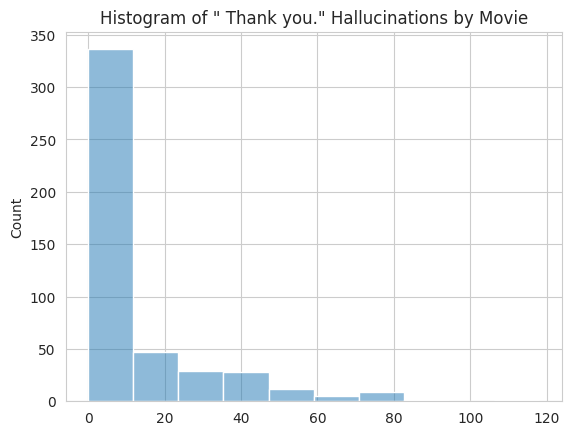

In [12]:
plotting.create_thank_you_hist(trans_df)
# TODO: consider evaluating per segment count or per character count

Text(0.5, 1.0, 'Histogram of Proportion of Text from Narrator by Movie')

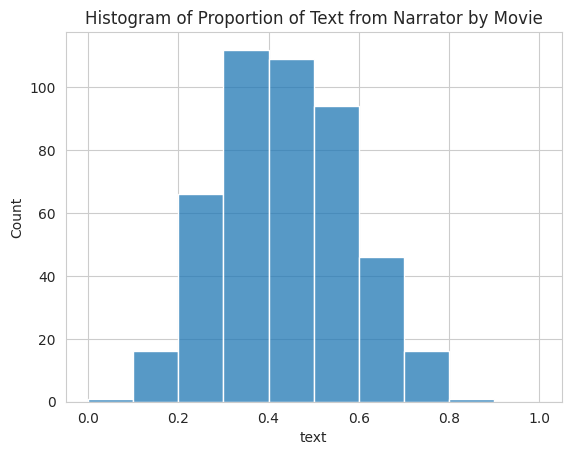

In [13]:
trans_wc_df = red_trans_df.groupby('movie').text.apply(' '.join).apply(md.process_text, excl_stopwords=False).apply(len)
subs_wc_df = filtered_subs_df.groupby('movie').text.apply(' '.join).apply(md.process_text, excl_stopwords=False).apply(len)

perc_narration_df = trans_wc_df / (subs_wc_df + trans_wc_df)

sns.histplot(perc_narration_df, binrange=(0, 1), bins=10)
plt.title('Histogram of Proportion of Text from Narrator by Movie')

In [14]:
perc_narration_df.sort_values(ascending=False).iloc[:5]

movie
The Substance          0.812051
John Wick Chapter 2    0.783263
The Apparition         0.769603
Mad Max Fury Road      0.767399
Dunkirk                0.767063
Name: text, dtype: float64

In [16]:
perc_narration_df.sort_values(ascending=True).iloc[:5]

movie
The Trial Of The Chicago 7    0.089152
Annie Hall                    0.116026
Whitney Can I Be Me           0.142206
Marriage Story                0.152443
Anatomy Of A Fall             0.152804
Name: text, dtype: float64

In [15]:
# TODO: fix overlapping issue of names
subs_text = ' '.join(filtered_subs_df.text)
trans_text = ' '.join(red_trans_df.text)
dataset = {'Subtitles': subs_text, 'Transcripts': trans_text}

excl_stopwords = True

for title, text in dataset.items():
    bigram_df = md.get_ngram_counts(text, 2, excl_stopwords=excl_stopwords)
    trigram_df = md.get_ngram_counts(text, 3, excl_stopwords=excl_stopwords)

    bigram_df['type'] = 'bigram'
    trigram_df['type'] = 'trigram'

    full_df = pd.concat([bigram_df, trigram_df])
    title = f"Bigram and Trigram Frequencies for {title}"
    plotting.plot_ngrams(full_df, title, os.path.join(plotting.output_dir, f'{title} ngram ranking.png'))

KeyboardInterrupt: 

Text(0.5, 1.0, 'Correlation of Ratings Categories')

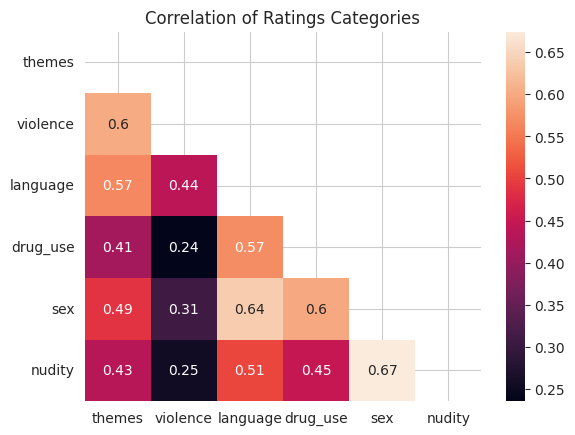

In [ ]:
ord_acb_df = acb_df.copy()
for col in md.full_cat_cols:
    ord_acb_df[col] = md.convert_col_to_ordinal(ord_acb_df[col])

corr_df = ord_acb_df[md.full_cat_cols].corr()
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.title('Correlation of Ratings Categories')

Text(0.5, 1.0, 'Counts per Aggregated Rating Category')

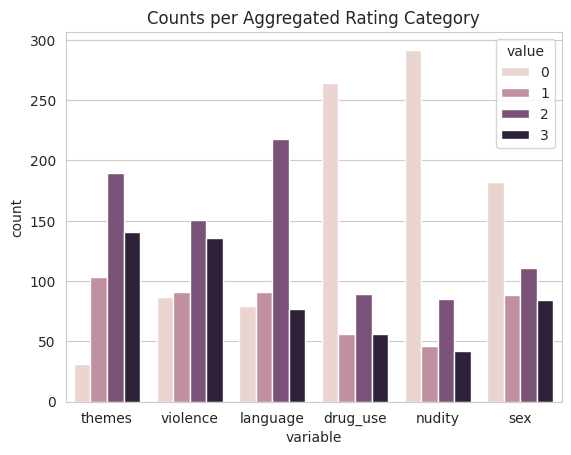

In [ ]:
melt_df = pd.melt(ord_acb_df, ['movie'], md.full_cat_cols)
sns.countplot(melt_df, x='variable', hue='value')
plt.title('Counts per Aggregated Rating Category')

/tmp/ipykernel_113078/235935399.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(full_ord_acb_df, x='Classification', palette=plotting.full_acb_palette[1:], order=md.classifications)


<Axes: xlabel='Classification', ylabel='count'>

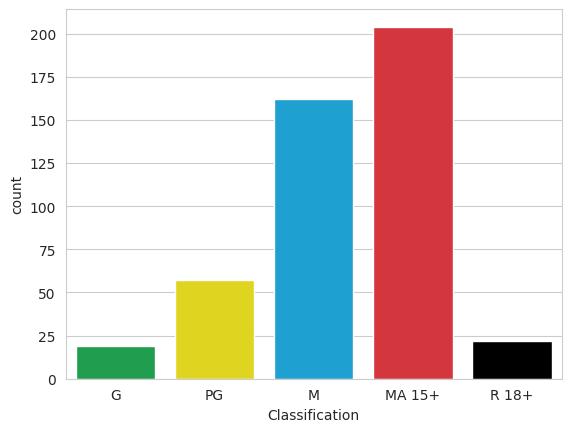

In [ ]:
full_ord_acb_df = acb_df.copy()
for col in md.full_cat_cols:
    full_ord_acb_df[col] = md.convert_col_to_ordinal(full_ord_acb_df[col], compact=False)

full_ord_acb_df['rating'] = full_ord_acb_df[md.full_cat_cols].max(axis=1)
full_ord_acb_df['Classification'] = np.select(
    [full_ord_acb_df['rating'].eq(ii) for ii in range(1, 6)],
    md.classifications,
    default='Error'
)

sns.countplot(full_ord_acb_df, x='Classification', palette=plotting.full_acb_palette[1:], order=md.classifications)

INFO - 2025-07-09 15:35:10,731 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2025-07-09 15:35:10,734 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


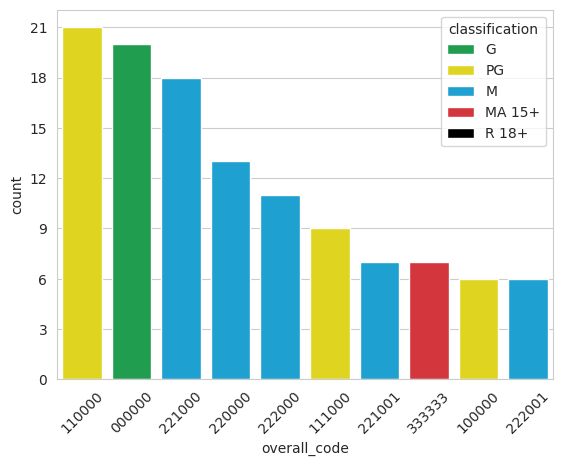

In [ ]:
ord_acb_df['overall_code'] = ord_acb_df[md.full_cat_cols].astype(str).agg(''.join, axis=1)
ord_acb_df['rating'] = ord_acb_df[md.full_cat_cols].max(axis=1)
ord_acb_df['classification'] = np.select(
    [ord_acb_df['rating'].eq(ii) for ii in range(len(md.classifications))],
    md.classifications,
    default='Error'
)
top_codes = ord_acb_df['overall_code'].value_counts()

top_10_codes = ord_acb_df[ord_acb_df.overall_code.isin(top_codes.index[:10])]
fig = sns.countplot(top_10_codes, x='overall_code', hue='classification', hue_order=md.classifications, order=top_codes.index[:10], palette=plotting.full_acb_palette[1:])
plt.xticks(rotation=45)
fig.axes.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()